## Provider Fraud Detection - Exploratory Data Analysis

## The goal of this EDA portion will be to understand the data I produced in the Wrangling work, find issues, and decide on modeling & preprocessing choices.

In [ ]:
# pulling in needed modules (my standard imports)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import ks_2samp



from pathlib import Path
import os
from IPython.display import display

# show plots inline
%matplotlib inline

In [ ]:
# loading final dataframe from the data wrangling step

AS_OF_STR = "2023-12-31"
PARQUET_DIR = Path("curated/training") / f"providers_nn_asof_{AS_OF_STR}.parquet"


# loading the final dataframe from the data wrangling step
df = pd.read_parquet(PARQUET_DIR, engine="pyarrow")
print(df.shape)
df.head()

(191700, 29)


,npi,state_abbr,zip5,entity_type_code,primary_taxonomy,npi_age_days,is_active,is_organization_subpart,is_sole_proprietor,total_services,...,w_stddev_submitted_charge,charge_allowed_ratio,payment_allowed_ratio,services_per_bene,bene_days_per_bene,has_puf,ever_excluded_asof,excluded_asof,is_fraud,is_excluded_asof
0,1003003179,NJ,08823,2.0,332B00000X,5934.0,1,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0,0
1,1003019233,IA,52240,2.0,310400000X,6052.0,1,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0,0
2,1003019639,NY,12180,1.0,133V00000X,6048.0,1,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0,0
3,1003031550,WI,53154,2.0,251300000X,6102.0,1,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0,0
4,1003033556,CA,90061,2.0,1223G0001X,6100.0,1,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0,0


In [ ]:
# exploring the dataset with df.info()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191700 entries, 0 to 191699
Data columns (total 29 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   npi                        191700 non-null  object 
 1   state_abbr                 183741 non-null  object 
 2   zip5                       183829 non-null  object 
 3   entity_type_code           183830 non-null  float64
 4   primary_taxonomy           183830 non-null  object 
 5   npi_age_days               183830 non-null  float64
 6   is_active                  191700 non-null  int32  
 7   is_organization_subpart    38217 non-null   float64
 8   is_sole_proprietor         143315 non-null  float64
 9   total_services             191700 non-null  float64
 10  total_beneficiaries        191700 non-null  float64
 11  total_bene_day_services    191700 non-null  float64
 12  num_unique_procedures      191700 non-null  float64
 13  frac_drug_services         19

In [ ]:
# exploring basic numeric statistics with describe()

df.describe()

,entity_type_code,npi_age_days,is_active,is_organization_subpart,is_sole_proprietor,total_services,total_beneficiaries,total_bene_day_services,num_unique_procedures,frac_drug_services,...,w_stddev_submitted_charge,charge_allowed_ratio,payment_allowed_ratio,services_per_bene,bene_days_per_bene,has_puf,ever_excluded_asof,excluded_asof,is_fraud,is_excluded_asof
count,183830.000000,183830.000000,191700.000000,38217.000000,143315.000000,1.917000e+05,191700.000000,191700.000000,191700.00000,191700.000000,...,191700.000000,191700.000000,191700.000000,191700.000000,191700.000000,191700.000000,6711.0,6711.0,191700.000000,191700.000000
mean,1.207893,3698.010064,0.958946,0.082319,0.335010,2.830473e+02,85.584048,139.971054,1.10711,0.005294,...,27.153017,0.509726,0.106945,0.450855,0.311179,0.139656,1.0,1.0,0.035008,0.035008
std,0.405801,2230.350420,0.198415,0.274854,0.471996,6.053471e+03,1273.968183,2190.487061,4.66307,0.040101,...,233.222103,1.948240,0.267107,3.194090,1.347530,0.346630,0.0,0.0,0.183800,0.183800
min,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.000000,0.000000
25%,1.000000,1598.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.000000,0.000000
50%,1.000000,3796.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.000000,0.000000
75%,1.000000,6095.000000,1.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.000000,0.000000
max,2.000000,6796.000000,1.000000,1.000000,1.000000,1.547347e+06,391196.000000,587072.000000,425.00000,1.000000,...,33931.716585,160.854829,1.000000,439.099462,71.500000,1.000000,1.0,1.0,1.000000,1.000000


In [ ]:
# listing dataframe columns

df.columns

Index(['npi', 'state_abbr', 'zip5', 'entity_type_code', 'primary_taxonomy',
       'npi_age_days', 'is_active', 'is_organization_subpart',
       'is_sole_proprietor', 'total_services', 'total_beneficiaries',
       'total_bene_day_services', 'num_unique_procedures',
       'frac_drug_services', 'frac_missing_zip', 'w_avg_submitted_charge',
       'w_avg_allowed', 'w_avg_payment', 'w_var_submitted_charge',
       'w_stddev_submitted_charge', 'charge_allowed_ratio',
       'payment_allowed_ratio', 'services_per_bene', 'bene_days_per_bene',
       'has_puf', 'ever_excluded_asof', 'excluded_asof', 'is_fraud',
       'is_excluded_asof'],
      dtype='object')

,dtype,non_null,missing_pct,n_unique
bene_days_per_bene,float64,191700,0.00%,17998
charge_allowed_ratio,float64,191700,0.00%,26753
entity_type_code,float64,183830,4.11%,2
ever_excluded_asof,float64,6711,96.50%,1
excluded_asof,float64,6711,96.50%,1
frac_drug_services,float64,191700,0.00%,288
frac_missing_zip,float64,191700,0.00%,1
has_puf,int32,191700,0.00%,2
is_active,int32,191700,0.00%,2
is_excluded_asof,int32,191700,0.00%,2


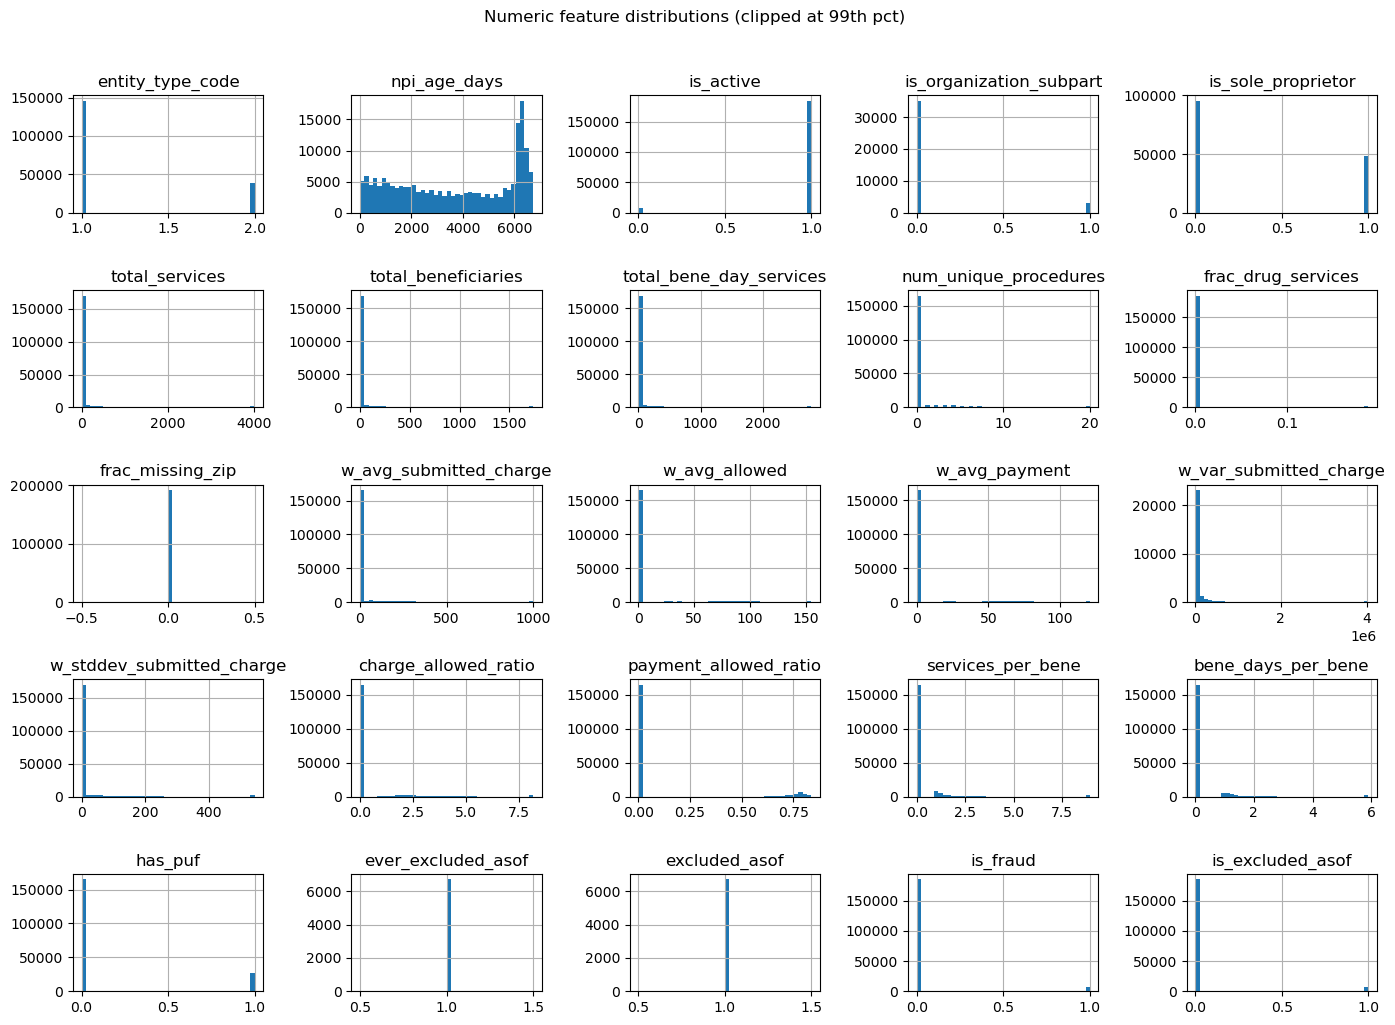


Top levels for npi (showing up to 20)


npi
1003003179    1
1669655338    1
1669601050    1
1669608329    1
1669624003    1
1669632352    1
1669633426    1
1669634044    1
1669638565    1
1669639308    1
1669642567    1
1669658951    1
1669730891    1
1669665709    1
1669672176    1
1669673760    1
1669680153    1
1669683074    1
1669685558    1
1669694006    1
Name: count, dtype: int64


Top levels for state_abbr (showing up to 20)


state_abbr
CA      22473
NY      13538
FL      12573
TX      11818
None     7959
OH       7824
PA       6916
MI       6849
IL       6401
NC       5359
MA       5184
WA       4963
NJ       4558
GA       4528
CO       3924
VA       3915
MD       3808
AZ       3477
TN       3306
MN       3166
Name: count, dtype: int64


Top levels for zip5 (showing up to 20)


zip5
None     7871
48334     454
77030     372
10016     247
19104     238
02115     229
60611     215
55905     206
92868     203
02114     197
78229     195
10029     181
91016     177
72205     174
46202     173
48109     171
80045     168
37232     166
92123     159
63110     159
Name: count, dtype: int64


Top levels for primary_taxonomy (showing up to 20)


primary_taxonomy
None          7870
106S00000X    7280
1041C0700X    6905
183500000X    6536
101YM0800X    6258
225100000X    6073
207Q00000X    5001
363LF0000X    4836
207R00000X    4474
235Z00000X    4208
1223G0001X    3958
390200000X    3818
111N00000X    3727
363A00000X    3218
101YP2500X    3192
171M00000X    3010
225X00000X    2811
122300000X    2729
163W00000X    2608
104100000X    2568
Name: count, dtype: int64

In [ ]:
# creating a quick data profile and previewing numeric and categorical distributions

# ensure i'm working with friendlier column names for all summaries: apply rename mapping
# only apply if the raw wrangling names exist (safe to run repeatedly)
rename_map = {
    "state_abbr": "state",
    "zip5": "zip5",
    "entity_type_code": "entity_type",
    "primary_taxonomy": "taxonomy",
    "npi_age_days": "days_since_enrollment",
    "is_active": "npi_active",
    "is_organization_subpart": "org_subpart_flag",
    "is_sole_proprietor": "sole_proprietor_flag",
    "total_services": "services_total",
    "total_beneficiaries": "beneficiaries_total",
    "total_bene_day_services": "beneficiary_days_total",
    "num_unique_procedures": "hcpcs_unique_count",
    "frac_drug_services": "drug_services_rate",
    "frac_missing_zip": "missing_zip_rate",
    "w_avg_submitted_charge": "avg_charge_w",
    "w_avg_allowed": "avg_allowed_w",
    "w_avg_payment": "avg_payment_w",
    "w_stddev_submitted_charge": "charge_std_w",
    "charge_allowed_ratio": "charge_to_allowed",
    "payment_allowed_ratio": "payment_to_allowed",
    "services_per_bene": "services_per_beneficiary",
    "bene_days_per_bene": "beneficiary_days_per_beneficiary",
    "has_puf": "has_claims_features",
    "is_fraud": "label_fraud",
    "is_excluded_asof": "status_excluded_asof"
}
if any(k in df.columns for k in rename_map.keys()):
    common = {k: v for k, v in rename_map.items() if k in df.columns}
    if common:
        df = df.rename(columns=common)

# data profile summary
prof = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "non_null": df.notna().sum(),
    "missing_pct": df.isna().mean().round(4),
    "n_unique": df.nunique(dropna=True)
}).sort_index()
display(prof.head(40).style.format({"missing_pct":"{:.2%}"}))

# Numeric distribution snapshot (trimmed at 99th pct for readability)
num_preview = df.select_dtypes(include=[np.number]).copy()
for c in num_preview.columns:
    num_preview[c] = num_preview[c].clip(upper=num_preview[c].quantile(0.99))
ax = num_preview.hist(bins=40, figsize=(14,10))
plt.suptitle("Numeric feature distributions (clipped at 99th pct)", y=1.02)
plt.tight_layout()
plt.show()

# Categorical cardinalities (top 20)
cat_preview = df.select_dtypes(exclude=[np.number]).columns.tolist()
for c in cat_preview:
    vc = df[c].value_counts(dropna=False).head(20)
    print(f"\nTop levels for {c} (showing up to 20)")
    display(vc)

In [ ]:
# reporting dataset shape

# exploring the shape of the data
print(f'Shape of the Provider Fraud Detection dataset: {df.shape}')

Shape of the Provider Fraud Detection dataset: (191700, 29)


In [ ]:
# checking missing values per column

# checking for the missing values for each column in this dataset
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns = ['count', 'percent']
missing.sort_values(by='count', ascending=False)


,count,percent
excluded_asof,184989,96.499218
ever_excluded_asof,184989,96.499218
w_var_submitted_charge,164928,86.034429
is_organization_subpart,153483,80.064163
is_sole_proprietor,48385,25.239958
state_abbr,7959,4.151800
zip5,7871,4.105895
entity_type_code,7870,4.105373
primary_taxonomy,7870,4.105373
npi_age_days,7870,4.105373


In [ ]:
# dropping redundant raw label columns that I won't use for modeling

# dropping redudant/raw label columns
df = df.drop(columns=["ever_excluded_asof", "excluded_asof", "w_var_submitted_charge"], errors="ignore")

In [ ]:
# re-checking dataframe info and available columns after pruning

df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191700 entries, 0 to 191699
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   npi                        191700 non-null  object 
 1   state_abbr                 183741 non-null  object 
 2   zip5                       183829 non-null  object 
 3   entity_type_code           183830 non-null  float64
 4   primary_taxonomy           183830 non-null  object 
 5   npi_age_days               183830 non-null  float64
 6   is_active                  191700 non-null  int32  
 7   is_organization_subpart    38217 non-null   float64
 8   is_sole_proprietor         143315 non-null  float64
 9   total_services             191700 non-null  float64
 10  total_beneficiaries        191700 non-null  float64
 11  total_bene_day_services    191700 non-null  float64
 12  num_unique_procedures      191700 non-null  float64
 13  frac_drug_services         19

Index(['npi', 'state_abbr', 'zip5', 'entity_type_code', 'primary_taxonomy',
       'npi_age_days', 'is_active', 'is_organization_subpart',
       'is_sole_proprietor', 'total_services', 'total_beneficiaries',
       'total_bene_day_services', 'num_unique_procedures',
       'frac_drug_services', 'frac_missing_zip', 'w_avg_submitted_charge',
       'w_avg_allowed', 'w_avg_payment', 'w_stddev_submitted_charge',
       'charge_allowed_ratio', 'payment_allowed_ratio', 'services_per_bene',
       'bene_days_per_bene', 'has_puf', 'is_fraud', 'is_excluded_asof'],
      dtype='object')

In [ ]:
# renaming columns to friendlier names (my mapping)

# renaming the columns to be more readable

rename_map = {
    "state_abbr": "state",
    "zip5": "zip5",
    "entity_type_code": "entity_type", # 1= individual, 2=organization
    "primary_taxonomy": "taxonomy",
    "npi_age_days": "days_since_enrollment",
    "is_active": "npi_active",
    "is_organization_subpart": "org_subpart_flag",
    "is_sole_proprietor": "sole_proprietor_flag",
    "total_services": "services_total",
    "total_beneficiaries": "beneficiaries_total",
    "total_bene_day_services": "beneficiary_days_total",
    "num_unique_procedures": "hcpcs_unique_count",
    "frac_drug_services": "drug_services_rate",
    "frac_missing_zip": "missing_zip_rate",
    "w_avg_submitted_charge": "avg_charge_w",
    "w_avg_allowed": "avg_allowed_w",
    "w_avg_payment": "avg_payment_w",
    "w_stddev_submitted_charge": "charge_std_w",
    "charge_allowed_ratio": "charge_to_allowed",
    "payment_allowed_ratio": "payment_to_allowed",
    "services_per_bene": "services_per_beneficiary",
    "bene_days_per_bene": "beneficiary_days_per_beneficiary",
    "has_puf": "has_claims_features",
    "is_fraud": "label_fraud", # this will be my target feature
    "is_excluded_asof": "status_excluded_asof" # this is only for reporting purposes, not used in modeling
}

df = df.rename(columns=rename_map)


In [ ]:
# quick sanity check on the target label distribution

# Basic label sanity
print(df["label_fraud"].value_counts(dropna=False))
print(f"Prevalence (downsampled): {df['label_fraud'].mean():.2%}")

label_fraud
0    184989
1      6711
Name: count, dtype: int64
Prevalence (downsampled): 3.50%


In [ ]:
# checking for duplicate NPIs (primary key)

# Duplicates on primary key
dup_npi = df["npi"].duplicated().sum()
print("Duplicate NPIs:", dup_npi)

Duplicate NPIs: 0


In [ ]:
# optional: consolidate duplicates (policy-driven) if I find any

# Optional: consolidate duplicates (choose policy)
if dup_npi > 0:
    # If you have a time column (adjust the name), keep the latest record per NPI
    time_col_guess = next((c for c in df.columns if "asof" in c.lower() or "date" in c.lower()), None)
    if time_col_guess is not None:
        df = (df.sort_values(time_col_guess)
                .groupby("npi", as_index=False)
                .tail(1))
    else:
        # Otherwise aggregate numerics, and mark label as any positive
        agg_spec = {c: "mean" for c in df.select_dtypes(include=[np.number]).columns if c not in ["label_fraud"]}
        agg_spec["label_fraud"] = "max"
        keep_first = [c for c in df.columns if c not in agg_spec and c != "npi"]
        df = (df.groupby("npi", as_index=False)
                .agg(agg_spec)
                .merge(df[["npi"] + keep_first].drop_duplicates("npi"), on="npi", how="left"))
    print("After NPI de-dup:", df.shape)
    print(f"Prevalence after NPI de-dup: {df['label_fraud'].mean():.2%}")



,rows,fraud_rate,pct
has_claims_features,,,
0,164928,4.06%,86.0%
1,26772,0.03%,14.0%



Top state by volume within has_claims_features buckets


,has_claims_features,state,rows,fraud_rate
9,0,CA,20356,3.76%
43,0,NY,11687,5.32%
14,0,FL,10830,4.61%
54,0,TX,10004,3.26%
44,0,OH,6759,7.10%
28,0,MI,5927,4.42%
48,0,PA,5585,4.60%
20,0,IL,5342,3.39%
35,0,NC,4443,1.91%
25,0,MA,4405,1.79%



Top entity_type by volume within has_claims_features buckets


,has_claims_features,entity_type,rows,fraud_rate
0,0,1.000000,120337,4.56%
1,0,2.000000,36805,1.20%
2,1,1.000000,25276,0.04%
3,1,2.000000,1412,0.00%



Top taxonomy by volume within has_claims_features buckets


,has_claims_features,taxonomy,rows,fraud_rate
34,0,106S00000X,7280,0.11%
30,0,1041C0700X,6589,1.70%
180,0,183500000X,6534,3.41%
3,0,101YM0800X,6246,2.15%
425,0,225100000X,4555,1.84%
489,0,235Z00000X,4172,0.79%
51,0,1223G0001X,3958,3.34%
760,0,390200000X,3721,0.46%
5,0,101YP2500X,3191,2.70%
225,0,207Q00000X,3185,15.54%


,missing_pct,count
org_subpart_flag,80.1%,153483
sole_proprietor_flag,25.2%,48385
state,4.2%,7959
zip5,4.1%,7871
entity_type,4.1%,7870
taxonomy,4.1%,7870
days_since_enrollment,4.1%,7870
npi,0.0%,0
avg_payment_w,0.0%,0
label_fraud,0.0%,0


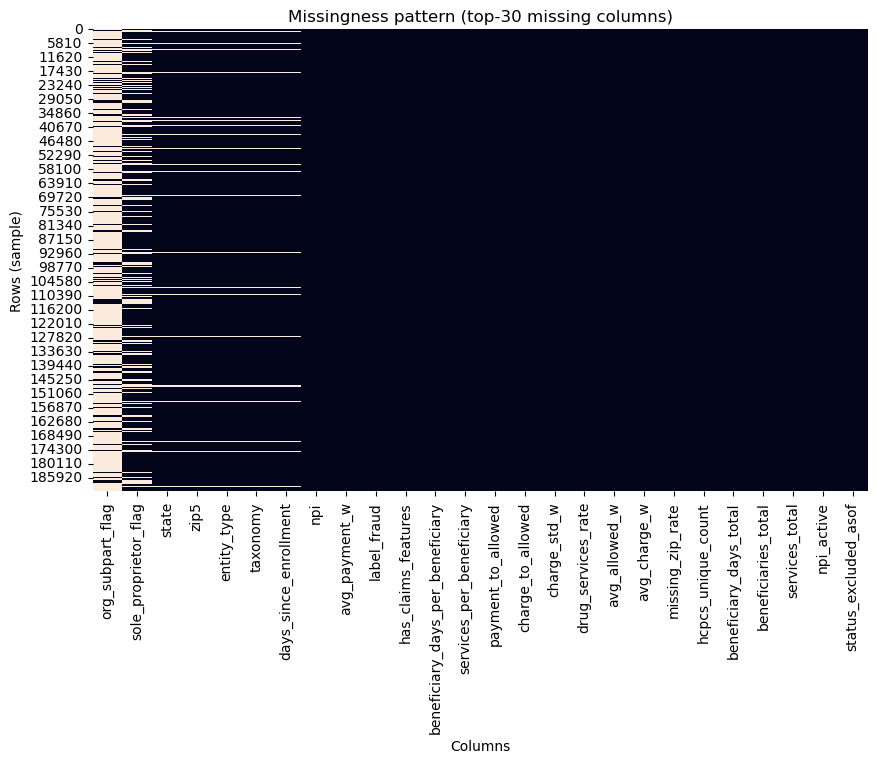

Possible leakage (AUC > 0.85 typically suspicious):


,feature,roc_auc,avg_precision
20,status_excluded_asof,1.000000,1.000000
1,days_since_enrollment,0.740667,0.071244
4,sole_proprietor_flag,0.584944,0.044504
3,org_subpart_flag,0.492114,0.034969
9,drug_services_rate,0.486377,0.034993
2,npi_active,0.461667,0.032618
14,charge_std_w,0.436447,0.034977
0,entity_type,0.430908,0.033462
17,services_per_beneficiary,0.428358,0.034963
12,avg_allowed_w,0.428353,0.034962


,feature,mi
20,status_excluded_asof,0.152059
2,npi_active,0.046637
0,entity_type,0.030773
1,days_since_enrollment,0.016815
4,sole_proprietor_flag,0.009399
19,has_claims_features,0.007477
8,hcpcs_unique_count,0.005693
15,charge_to_allowed,0.005528
18,beneficiary_days_per_beneficiary,0.005485
12,avg_allowed_w,0.005416


Potentially leaky by name: ['status_excluded_asof']
Highly correlated pairs (>=0.95): 66
Highly correlated pairs (>=0.95): 66


,f1,f2,abs_spearman
147,avg_allowed_w,avg_payment_w,0.999867
79,services_total,beneficiary_days_total,0.999814
92,beneficiaries_total,beneficiary_days_total,0.999228
93,beneficiaries_total,hcpcs_unique_count,0.999092
78,services_total,beneficiaries_total,0.999054
177,services_per_beneficiary,beneficiary_days_per_beneficiary,0.999021
138,avg_charge_w,avg_allowed_w,0.998368
139,avg_charge_w,avg_payment_w,0.998364
105,beneficiary_days_total,hcpcs_unique_count,0.998339
80,services_total,hcpcs_unique_count,0.998255



KS test: features with strongest distribution differences by bucket


,feature,ks_stat,p_value
18,beneficiary_days_per_beneficiary,1.000000,0.0
17,services_per_beneficiary,1.000000,0.0
16,payment_to_allowed,1.000000,0.0
15,charge_to_allowed,1.000000,0.0
5,services_total,1.000000,0.0
6,beneficiaries_total,1.000000,0.0
7,beneficiary_days_total,1.000000,0.0
8,hcpcs_unique_count,1.000000,0.0
19,has_claims_features,1.000000,0.0
11,avg_charge_w,1.000000,0.0


In [ ]:
# coverage and completeness checks; ensure bucket flags and target are clean

# some coverage and completeness checks

# ensuring bucket is clean integers
if "has_claims_features" in df.columns:
    df["has_claims_features"] = df["has_claims_features"].fillna(0).astype(int)
else:
    raise ValueError("Column 'has_claims_features' not found. Expected after wrangling.")

# inserting scaffold guards
assert "label_fraud" in df.columns, "Missing target column 'label_fraud'."
df["label_fraud"] = df["label_fraud"].fillna(0).astype(int)

# cohort size and fraud prevalence by bucket
bucket = (
    df.groupby("has_claims_features")
      .agg(rows=("npi","size"),
           fraud_rate=("label_fraud","mean"))
      .assign(pct=lambda x: x["rows"] / len(df))
      .sort_index()
)
display(bucket.style.format({"pct":"{:.1%}","fraud_rate":"{:.2%}"}))

# slicing the bucket by key categoricals
for col in [c for c in ["state","entity_type","taxonomy"] if c in df.columns]:
    tmp = (df.groupby(["has_claims_features", col])
             .agg(rows=("npi","size"), fraud_rate=("label_fraud","mean"))
             .reset_index())
    # show top 15 by rows within each bucket
    out = tmp.sort_values(["has_claims_features","rows"], ascending=[True,False])\
             .groupby("has_claims_features").head(15)
    print(f"\nTop {col} by volume within has_claims_features buckets")
    display(out.style.format({"fraud_rate":"{:.2%}"}))


# missingness overview: table of top 10 missing columns
miss_tbl = (df.isna().mean().sort_values(ascending=False)
              .to_frame("missing_pct")
              .assign(count=lambda x: (x["missing_pct"]*len(df)).round().astype(int)))
display(miss_tbl.head(10).style.format({"missing_pct":"{:.1%}"}))


# missingness heatmap (subsetting to the 30 most missing columns for visibility)
top_cols = miss_tbl.head(30).index.tolist()
if top_cols:
    plt.figure(figsize=(10,6))
    sns.heatmap(df[top_cols].isna(), cbar=False)
    plt.title("Missingness pattern (top-30 missing columns)")
    plt.xlabel("Columns")
    plt.ylabel("Rows (sample)")
    plt.show()

# having a label leakage check
y = df["label_fraud"].astype(int).values

# Exclude identifier-like numerics from signal checks
id_like = [c for c in ["npi", "tin", "ein", "org_id"] if c in df.columns]

X_num = (df.select_dtypes(include=[np.number])
           .drop(columns=["label_fraud"] + id_like, errors="ignore"))
num_feats = X_num.columns.tolist()

# 1A: Single-feature ROC AUC / AP
rows = []
for f in num_feats:
    # make a 1-D array; fill NaNs with the feature median
    xv = X_num[f].fillna(X_num[f].median()).to_numpy().ravel()
    try:
        # guard: if the feature is constant after fill, AUC/AP are undefined
        if np.all(xv == xv[0]):
            auc, ap = (np.nan, np.nan)
        else:
            auc = roc_auc_score(y, xv)
            ap  = average_precision_score(y, xv)
    except Exception:
        auc, ap = (np.nan, np.nan)
    rows.append((f, auc, ap))

single_auc = (pd.DataFrame(rows, columns=["feature","roc_auc","avg_precision"])
                .sort_values("roc_auc", ascending=False))
print("Possible leakage (AUC > 0.85 typically suspicious):")
display(single_auc.head(25))


# 1B: Mutual Information (secondary lens)
mi = mutual_info_classif(X_num.fillna(X_num.median()), y, discrete_features=False, random_state=0)
mi_tbl = pd.DataFrame({"feature": num_feats, "mi": mi}).sort_values("mi", ascending=False)
display(mi_tbl.head(25))

# 1C: Name heuristics
suspect_substrings = ["excluded","sanction","oig","investigat","clawback","recovery",
                      "post","asof_","denial","appeal"]
suspects = [c for c in df.columns if any(s in c.lower() for s in suspect_substrings)]
print("Potentially leaky by name:", suspects)


# addressing redundancy & multicollinearity (spearman >= 0.95)
num = (df.select_dtypes(include=[np.number])
         .drop(columns=["label_fraud"] + id_like, errors="ignore"))
corr = num.corr(method="spearman").abs()

pairs = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
              .stack()
              .reset_index())
pairs.columns = ["f1","f2","abs_spearman"]
high = pairs[pairs["abs_spearman"]>=0.95].sort_values("abs_spearman", ascending=False)
print("Highly correlated pairs (>=0.95):", len(high))
display(high.head(40))


# checking to see if numeric distributions are different between buckets
num_cols = (df.select_dtypes(include=[np.number])
              .drop(columns=["label_fraud"] + id_like, errors="ignore")
              .columns)

ks_rows = []
for c in num_cols:
    a = df.loc[df["has_claims_features"]==1, c].dropna()
    b = df.loc[df["has_claims_features"]==0, c].dropna()
    if len(a)>50 and len(b)>50:
        stat, p = ks_2samp(a, b)
        ks_rows.append((c, stat, p))
ks_tbl = (pd.DataFrame(ks_rows, columns=["feature","ks_stat","p_value"])
          .sort_values("ks_stat", ascending=False))
print("\nKS test: features with strongest distribution differences by bucket")
display(ks_tbl.head(15))

In [ ]:
# categorical cardinalities to plan encoding

# cardinality of categorical features (to plan for encoding)
cat_cols = [c for c in ["state","entity_type","taxonomy"] if c in df.columns]
for c in cat_cols:
    vc = df[c].value_counts(dropna=False)
    print(f"\n{c}: {len(vc)} unique values")
    display(vc.head(15))



state: 64 unique values


state
CA      22473
NY      13538
FL      12573
TX      11818
None     7959
OH       7824
PA       6916
MI       6849
IL       6401
NC       5359
MA       5184
WA       4963
NJ       4558
GA       4528
CO       3924
Name: count, dtype: int64


entity_type: 3 unique values


entity_type
1.0    145613
2.0     38217
NaN      7870
Name: count, dtype: int64


taxonomy: 769 unique values


taxonomy
None          7870
106S00000X    7280
1041C0700X    6905
183500000X    6536
101YM0800X    6258
225100000X    6073
207Q00000X    5001
363LF0000X    4836
207R00000X    4474
235Z00000X    4208
1223G0001X    3958
390200000X    3818
111N00000X    3727
363A00000X    3218
101YP2500X    3192
Name: count, dtype: int64

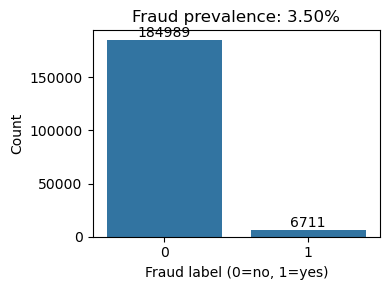

In [ ]:
# visualizing class balance for the fraud label

# target feature distribution
fig, ax = plt.subplots(figsize=(4,3))
sns.countplot(x="label_fraud", data=df, ax=ax)
ax.set_xlabel("Fraud label (0=no, 1=yes)")
ax.set_ylabel("Count")
ax.bar_label(ax.containers[0])
ax.set_title(f"Fraud prevalence: {df['label_fraud'].mean():.2%}")
plt.tight_layout()
plt.show()


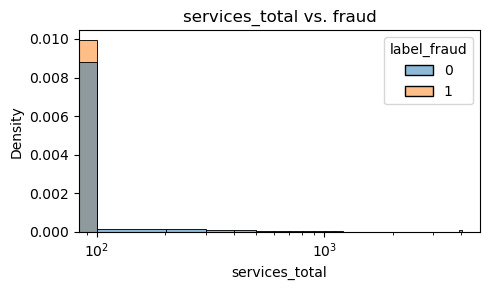

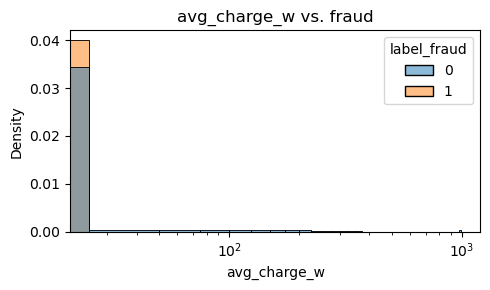

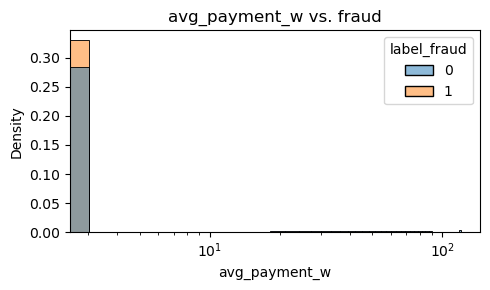

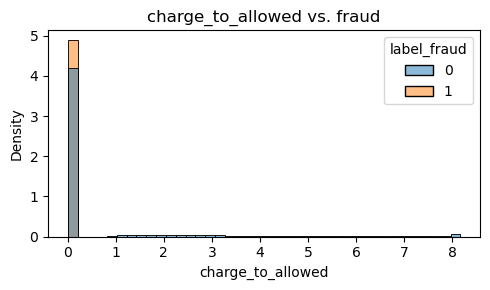

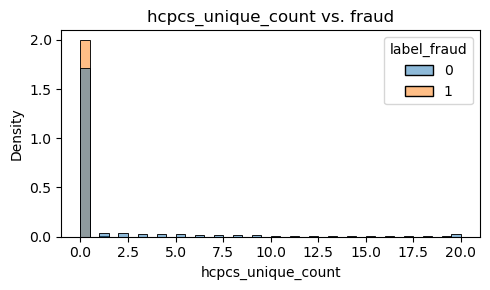

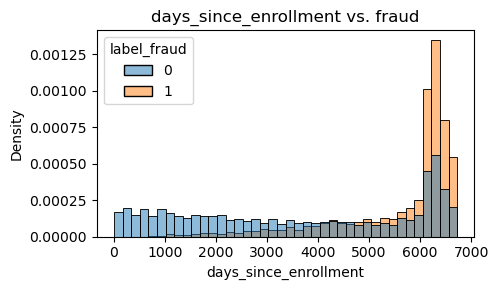

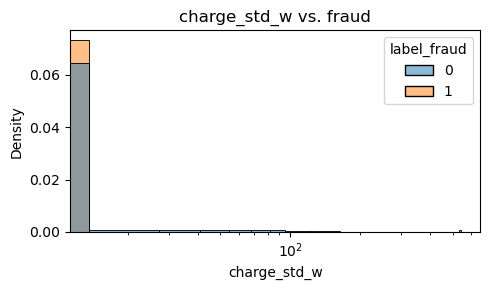

In [ ]:
# plotting selected numeric features against the target for intuition

# numeric feature distribution vs target

# choose representative numeric features (adjust as you like)
num_cols_view = [
    "services_total","avg_charge_w","avg_payment_w","charge_to_allowed",
    "hcpcs_unique_count","days_since_enrollment","charge_std_w"
]
present = [c for c in num_cols_view if c in df.columns]

for c in present:
    fig, ax = plt.subplots(figsize=(5,3))
    x = df[c].clip(upper=df[c].quantile(0.99))  # clip for readability
    sns.histplot(x=x, hue=df["label_fraud"], bins=40, stat="density",
                 common_norm=False, ax=ax)
    ax.set_title(f"{c} vs. fraud")
    if c in {"services_total","avg_charge_w","avg_payment_w","charge_std_w"}:
        ax.set_xscale("log")
    plt.tight_layout()
    plt.show()


In [ ]:
# plotting categorical fraud rates for top categories
def plot_cat_rate(df, col, top_n=15):
    if col not in df.columns: return
    top_vals = df[col].value_counts().head(top_n).index
    tmp = (df[df[col].isin(top_vals)]
           .groupby(col)["label_fraud"]
           .agg(rate="mean", count="size")
           .sort_values("rate", ascending=False))
    fig, ax = plt.subplots(figsize=(6,3.5))
    sns.barplot(x=tmp.index.astype(str), y=tmp["rate"], ax=ax)
    ax.set_ylabel("Fraud rate")
    ax.set_xlabel(col)
    ax.set_title(f"{col}: fraud rate (top {top_n} by volume)")
    ax.tick_params(axis="x", rotation=45)
    plt.tight_layout()
    display(tmp)
    
plt.show()


for c in ["state","entity_type","taxonomy"]:
    plot_cat_rate(df, c, top_n=15)


,rate,count
state,,
OH,0.061350,7824
NY,0.046092,13538
FL,0.039688,12573
MI,0.038254,6849
PA,0.037160,6916
CA,0.034085,22473
IL,0.028433,6401
TX,0.027670,11818
NJ,0.027424,4558


,rate,count
entity_type,,
1.0,0.037744,145613
2.0,0.011592,38217


,rate,count
taxonomy,,
207Q00000X,0.099180,5001
111N00000X,0.087738,3727
207R00000X,0.087394,4474
183500000X,0.034119,6536
1223G0001X,0.033350,3958
101YP2500X,0.026942,3192
363A00000X,0.026103,3218
101YM0800X,0.021413,6258
363LF0000X,0.019851,4836


In [ ]:
# pooling rare categories into an 'Other' bucket to simplify encoding
import json
from pathlib import Path

ARTIFACTS_DIR = Path("curated/training")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

pooled_map = {}

def rare_pool(frame, col, min_count=200):
    vc = frame[col].value_counts(dropna=False)
    rare_vals = vc[vc < min_count].index
    new_col = f"{col}_rare_pooled"
    frame[new_col] = frame[col].where(~frame[col].isin(rare_vals), f"Other_{col}")
    pooled_map[new_col] = {
        "pooled_into": f"Other_{col}",
        "pooled_levels": [str(x) for x in rare_vals.tolist()]
    }
    return new_col, vc, rare_vals

pooled_cols = []
for c in [c for c in ["state","entity_type","taxonomy"] if c in df.columns]:
    newc, vc, rares = rare_pool(df, c, min_count=200)  # tune threshold
    pooled_cols.append(newc)
    print(f"{c}: pooled {len(rares)} rare levels into '{newc}'")

# save pooled mapping for reproducibility
with open(ARTIFACTS_DIR / f"pooled_levels_{AS_OF_STR}.json", "w") as f:
    json.dump(pooled_map, f, indent=2)
print("Saved pooled level mappings to:", ARTIFACTS_DIR)

state: pooled 11 rare levels into 'state_rarepooled'
entity_type: pooled 0 rare levels into 'entity_type_rarepooled'
taxonomy: pooled 640 rare levels into 'taxonomy_rarepooled'


In [ ]:
# capping extreme outliers separately by has_claims_features bucket

# ensure i keep an unmodified snapshot for pre-impute analyses
if 'preimp' not in globals():
    preimp = df.copy()

# outlier capping
caps = {}
cap_cols = [c for c in ["services_total","avg_charge_w","avg_payment_w",
                        "charge_to_allowed","payment_to_allowed","charge_std_w"]
            if c in df.columns]
for c in cap_cols:
    caps[c] = {}
    for b in [0,1]:
        q = df.loc[df["has_claims_features"]==b, c].quantile(0.995)
        df.loc[df["has_claims_features"]==b, c] = df.loc[df["has_claims_features"]==b, c].clip(upper=q)
        caps[c][b] = float(q)
print("Recorded caps:", caps)

Recorded caps: {'services_total': {0: 0.0, 1: 43484.77950000006}, 'avg_charge_w': {0: 0.0, 1: 3772.863697127241}, 'avg_payment_w': {0: 0.0, 1: 390.432919692906}, 'charge_to_allowed': {0: 0.0, 1: 23.346968701932507}, 'payment_to_allowed': {0: 0.0, 1: 1.0}, 'charge_std_w': {0: 0.0, 1: 3034.7898530338316}}


In [ ]:
# building a pre-impute snapshot and creating missingness indicators

# only create preimp if a true pre-cap snapshot wasn't already captured
if 'preimp' not in globals():
    preimp = df.copy()

claims_cols = [c for c in preimp.columns if c.endswith("_w") or c in
               ["services_total","hcpcs_unique_count","charge_to_allowed","payment_to_allowed"]]
preimp["claims_feat_coverage"] = 1 - preimp[claims_cols].isna().mean(axis=1) if claims_cols else 0.0
preimp["claims_volume"] = preimp.get("services_total", pd.Series(0, index=preimp.index)).fillna(0)

# persist missingness as durable features on df (survive imputation)
claims_like = [c for c in preimp.columns if c.endswith("_w")] + \
              [c for c in ["services_total","hcpcs_unique_count"] if c in preimp.columns]
for c in claims_like:
    df[f"miss_{c}"] = preimp[c].isna().astype(int)

In [ ]:
# creating imputation maps per bucket and persisting caps & impute map

# imputation
num_impute_map = {}
# exclude identifier-like numerics from imputation
id_like = [c for c in ["npi", "tin", "ein", "org_id"] if c in df.columns]
num_cols_for_impute = df.select_dtypes(include=[np.number]).columns.difference(["label_fraud"] + id_like)
for c in num_cols_for_impute:
    med0 = df.loc[df["has_claims_features"]==0, c].median()
    med1 = df.loc[df["has_claims_features"]==1, c].median()
    num_impute_map[c] = {0: float(med0) if pd.notna(med0) else 0.0,
                         1: float(med1) if pd.notna(med1) else 0.0}

for b in [0,1]:
    idx = df["has_claims_features"]==b
    for c in num_impute_map:
        df.loc[idx, c] = df.loc[idx, c].fillna(num_impute_map[c][b])

# ensure no identifier-like numerics were accidentally filled
for ident in id_like:
    if ident in df.columns:
        # keep original identity columns as-is; do not treat them as features accidentally
        df[ident] = df[ident]

for c in df.select_dtypes(exclude=[np.number]).columns:
    df[c] = df[c].fillna("MISSING")

# post-impute checks: no numeric NaNs remain (except intentionally excluded ids)
numeric_cols_after = [c for c in df.select_dtypes(include=[np.number]).columns if c not in ["label_fraud"] + id_like]
remaining_nans = df[numeric_cols_after].isna().sum().sum()
assert remaining_nans == 0, f"found {remaining_nans} numeric NaNs after imputation"

# post-impute checks: categorical columns have no NaNs
cat_nans = df.select_dtypes(exclude=[np.number]).isna().sum().sum()
assert cat_nans == 0, f"found {cat_nans} categorical NaNs after imputation"

print("Stored numeric impute map per bucket.")

import json
ARTIFACTS_DIR = Path("curated/training")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

with open(ARTIFACTS_DIR / f"caps_{AS_OF_STR}.json", "w") as f:
    json.dump(caps, f, indent=2)

with open(ARTIFACTS_DIR / f"impute_map_{AS_OF_STR}.json", "w") as f:
    json.dump(num_impute_map, f, indent=2)

print("Saved caps & impute map to:", ARTIFACTS_DIR)

Stored numeric impute map per bucket.
Saved caps & impute map to: curated/training


In [ ]:
# examining fraud rate over time and summarizing router driver candidates (pre-impute)

# target imprint & router drivers
time_col = next((c for c in df.columns
                 if ("month" in c.lower() or "asof" in c.lower()) and c not in ["AS_OF_STR","asof_string"]), None)

if time_col is not None:
    by_time = (df.groupby([time_col, "has_claims_features"])["label_fraud"]
                 .agg(rate="mean", count="size").reset_index())
    print("Fraud rate over time by bucket (last 12 rows):")
    display(by_time.tail(12))

# Router driver candidates (use PRE-IMPUTE snapshot)
print("Router driver summaries (pre-impute view):")
display(preimp[["claims_feat_coverage","claims_volume"]].describe(include="all"))


Fraud rate over time by bucket (last 12 rows):


,status_excluded_asof,has_claims_features,rate,count
0,0,0,0.0,158226
1,0,1,0.0,26763
2,1,0,1.0,6702
3,1,1,1.0,9


Router driver summaries (pre-impute view):


,claims_feat_coverage,claims_volume
count,191700.0,191700.000000
mean,1.0,210.652633
std,0.0,1680.749760
min,1.0,0.000000
25%,1.0,0.000000
50%,1.0,0.000000
75%,1.0,0.000000
max,1.0,43484.779500


In [ ]:
# computing population stability index and assigning train/valid folds

def population_stability_index(a, b, bins=20):
    a = pd.Series(a).replace([np.inf, -np.inf], np.nan).dropna()
    b = pd.Series(b).replace([np.inf, -np.inf], np.nan).dropna()
    if a.nunique() < 2 or b.nunique() < 2:
        return 0.0
    qs = np.linspace(0, 1, bins+1)
    cuts = a.quantile(qs).unique()
    a_bins = pd.cut(a, bins=np.unique(cuts), include_lowest=True)
    b_bins = pd.cut(b, bins=np.unique(cuts), include_lowest=True)
    a_pct = a_bins.value_counts(normalize=True, sort=False)
    b_pct = b_bins.value_counts(normalize=True, sort=False)
    psi = ((a_pct - b_pct) * np.log((a_pct + 1e-8) / (b_pct + 1e-8))).sum()
    return float(psi)

if time_col is None:
    df["_fold"] = "train"
    df.loc[df.sample(frac=0.2, random_state=42).index, "_fold"] = "valid"
else:
    ordered = sorted(df[time_col].dropna().unique())
    cutoff = ordered[int(0.8*len(ordered))] if len(ordered) >= 5 else ordered[-1]
    df["_fold"] = np.where(df[time_col] <= cutoff, "train", "valid")

stab=[]
for c in df.select_dtypes(include=[np.number]).columns.difference(["label_fraud"]):
    psi = population_stability_index(df.loc[df["_fold"]=="train", c],
                                     df.loc[df["_fold"]=="valid", c])
    stab.append((c, psi))
psi_tbl = pd.DataFrame(stab, columns=["feature","psi"]).sort_values("psi", ascending=False)
print("Top unstable by PSI:")
display(psi_tbl.head(20))

Top unstable by PSI:


,feature,psi
0,avg_allowed_w,0.0
1,avg_charge_w,0.0
26,sole_proprietor_flag,0.0
25,services_total,0.0
24,services_per_beneficiary,0.0
23,payment_to_allowed,0.0
22,org_subpart_flag,0.0
21,npi_active,0.0
20,missing_zip_rate,0.0
19,miss_services_total,0.0


In [ ]:
# ks-tests to find features that separate the fraud label

ks_rows = []
num_cols_lbl = (df.select_dtypes(include=[np.number])
                  .drop(columns=["label_fraud"] + id_like, errors="ignore")
                  .columns)
for c in num_cols_lbl:
    a = df.loc[df["label_fraud"]==1, c].dropna()
    b = df.loc[df["label_fraud"]==0, c].dropna()
    if len(a)>50 and len(b)>50:
        stat, p = ks_2samp(a, b)
        ks_rows.append((c, stat, p))
ks_lbl = pd.DataFrame(ks_rows, columns=["feature","ks_stat","p_value"])\
         .sort_values("ks_stat", ascending=False)
print("Features with strongest separation (KS):")
display(ks_lbl.head(25))

Features with strongest separation (KS):


,feature,ks_stat,p_value
20,status_excluded_asof,1.000000,0.000000e+00
1,days_since_enrollment,0.398442,0.000000e+00
4,sole_proprietor_flag,0.169888,7.110140e-164
16,payment_to_allowed,0.143625,4.925491e-117
15,charge_to_allowed,0.143454,9.345340e-117
18,beneficiary_days_per_beneficiary,0.143332,1.476481e-116
13,avg_payment_w,0.143332,1.476481e-116
12,avg_allowed_w,0.143332,1.476481e-116
11,avg_charge_w,0.143332,1.476481e-116
8,hcpcs_unique_count,0.143332,1.476481e-116


In [ ]:
# exploring possible router thresholds by coverage and volume

print("Candidate router thresholds (pre-impute): share & fraud rate in claims-rich")
for thr_cov in [0.5, 0.7, 0.8, 0.9]:
    for thr_vol in [10, 50, 100]:
        mask = (preimp["claims_feat_coverage"]>=thr_cov) & (preimp["claims_volume"]>=thr_vol)
        share = mask.mean()
        fr = df.loc[mask, "label_fraud"].mean() if share>0 else np.nan
        print(f"coverage≥{thr_cov:0.2f}, volume≥{thr_vol:>3}: share={share:6.2%}, fraud_rate={fr:6.2%}")


Candidate router thresholds (pre-impute): share & fraud rate in claims-rich
coverage≥0.50, volume≥ 10: share=13.97%, fraud_rate= 0.03%
coverage≥0.50, volume≥ 50: share=12.46%, fraud_rate= 0.03%
coverage≥0.50, volume≥100: share=11.23%, fraud_rate= 0.03%
coverage≥0.70, volume≥ 10: share=13.97%, fraud_rate= 0.03%
coverage≥0.70, volume≥ 50: share=12.46%, fraud_rate= 0.03%
coverage≥0.70, volume≥100: share=11.23%, fraud_rate= 0.03%
coverage≥0.80, volume≥ 10: share=13.97%, fraud_rate= 0.03%
coverage≥0.80, volume≥ 50: share=12.46%, fraud_rate= 0.03%
coverage≥0.80, volume≥100: share=11.23%, fraud_rate= 0.03%
coverage≥0.90, volume≥ 10: share=13.97%, fraud_rate= 0.03%
coverage≥0.90, volume≥ 50: share=12.46%, fraud_rate= 0.03%
coverage≥0.90, volume≥100: share=11.23%, fraud_rate= 0.03%


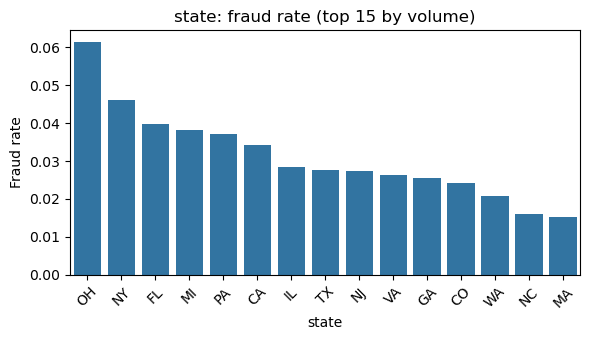

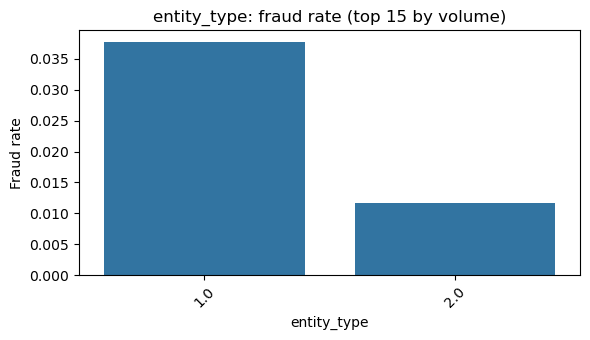

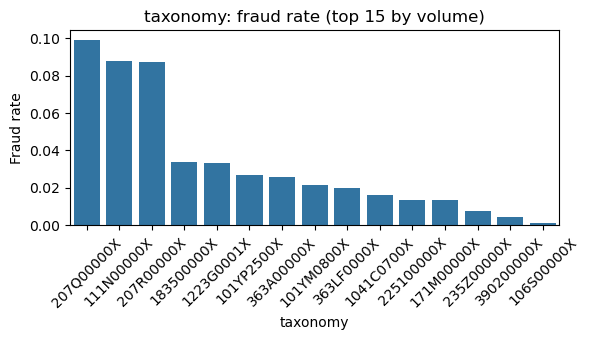

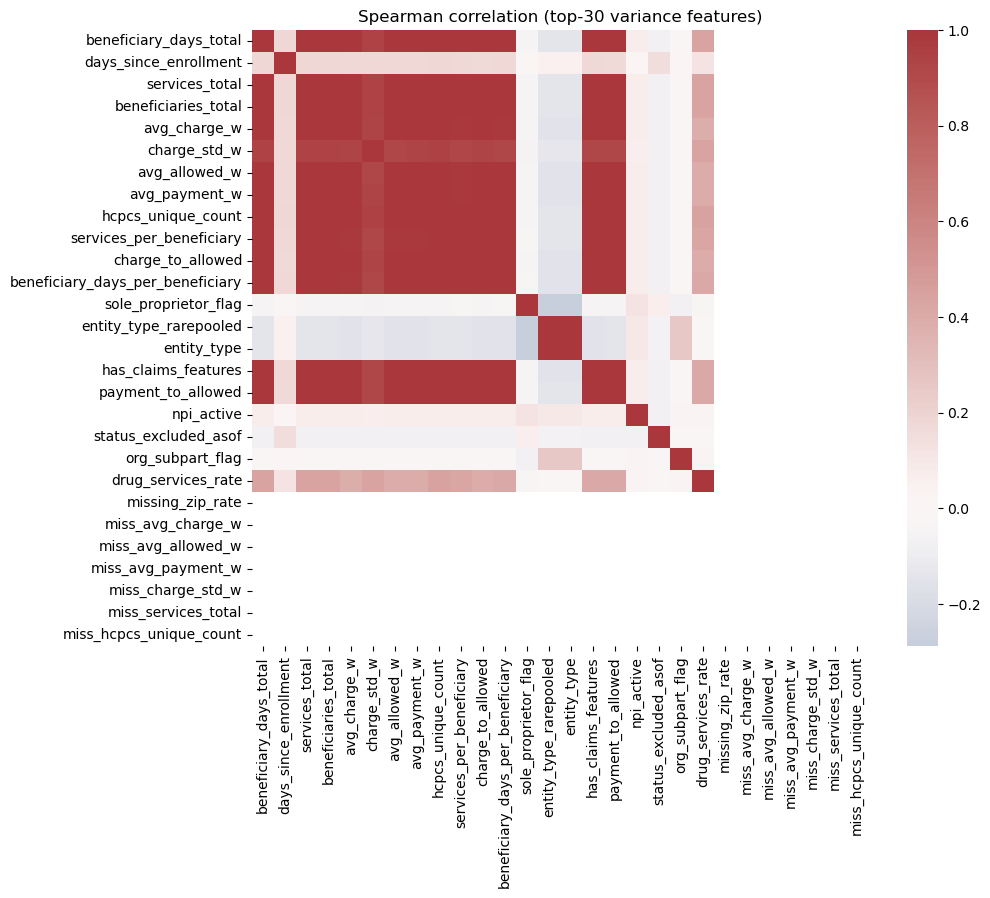

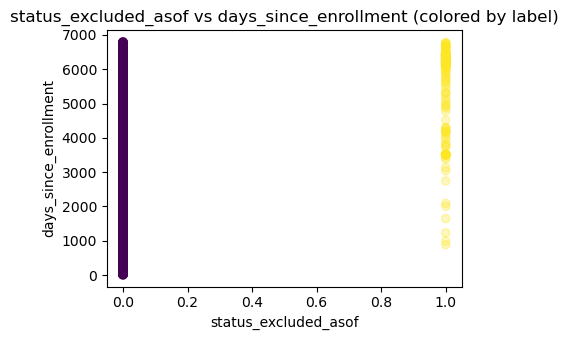

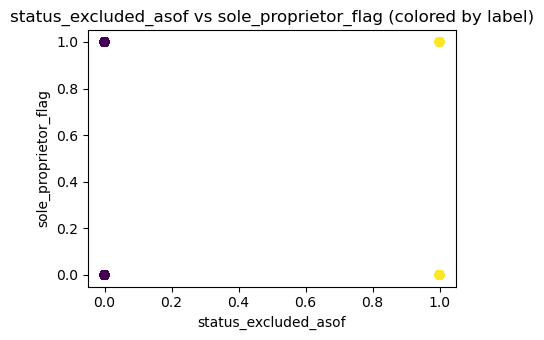

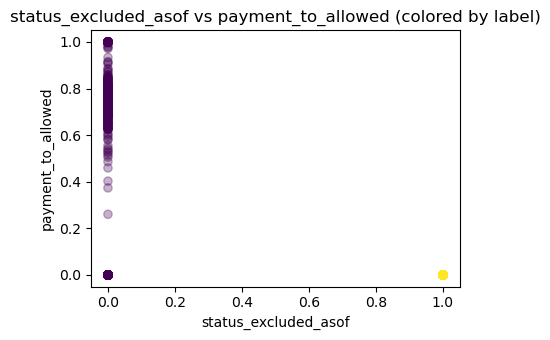

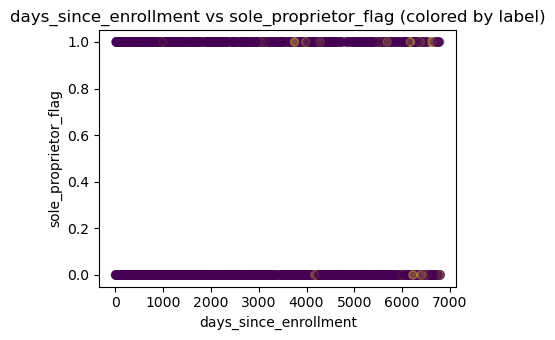

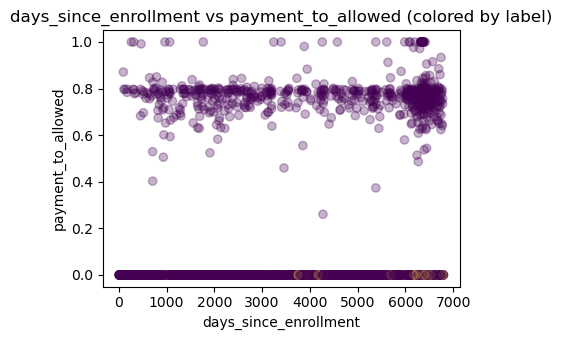

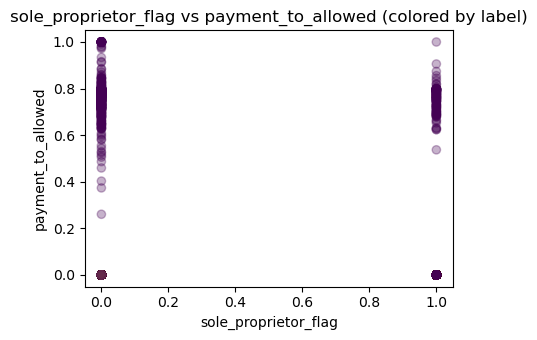

In [ ]:
# plotting correlation heatmap and pairwise scatter for top discriminators

# Correlation heatmap (Spearman, clipped to top 30 most variable features for readability)
num_all = df.select_dtypes(include=[np.number]).drop(columns=["label_fraud"], errors="ignore").copy()
var_rank = num_all.var().sort_values(ascending=False).head(30).index
corr30 = num_all[var_rank].corr(method="spearman")
plt.figure(figsize=(10,8))
sns.heatmap(corr30, cmap="vlag", center=0, square=True)
plt.title("Spearman correlation (top-30 variance features)")
plt.show()

# Pairwise scatter for top 4 discriminators (by KS)
top4 = ks_lbl["feature"].head(4).tolist() if "ks_lbl" in globals() else var_rank[:4].tolist()
sample = df.sample(min(5000, len(df)), random_state=42)  # keep plots light
for i in range(len(top4)-1):
    for j in range(i+1, len(top4)):
        x, y = top4[i], top4[j]
        plt.figure(figsize=(4.5,3.5))
        plt.scatter(sample[x], sample[y], c=sample["label_fraud"], alpha=0.3)
        plt.xlabel(x); plt.ylabel(y); plt.title(f"{x} vs {y} (colored by label)")
        plt.tight_layout(); plt.show()

In [ ]:
# creating eda-only feature candidates: log transforms, ratios, peer z-scores

feat_notes = []

# (a) Log transforms for heavy-tail monetary/volume
log_cols = [c for c in ["services_total","avg_charge_w","avg_payment_w","charge_std_w"]
            if c in df.columns]
for c in log_cols:
    newc = f"log1p_{c}"
    df[newc] = np.log1p(df[c].clip(lower=0))
    feat_notes.append(newc)

# (b) Ratios & normalized behaviors
if set(["avg_charge_w","avg_allowed_w"]).issubset(df.columns):
    df["charge_over_allowed"] = df["avg_charge_w"] / (df["avg_allowed_w"] + 1e-6)
    feat_notes.append("charge_over_allowed")
if set(["avg_payment_w","avg_allowed_w"]).issubset(df.columns):
    df["payment_over_allowed"] = df["avg_payment_w"] / (df["avg_allowed_w"] + 1e-6)
    feat_notes.append("payment_over_allowed")

# (c) Peer z-scores within taxonomy × state (behavior vs peers)
peer_keys = [k for k in ["taxonomy","state"] if k in df.columns]
peer_base = [c for c in ["services_total","hcpcs_unique_count","avg_charge_w","avg_payment_w"]
             if c in df.columns]
if len(peer_keys) == 2 and peer_base:
    grp = df.groupby(peer_keys)
    for c in peer_base:
        mu = grp[c].transform("mean")
        sd = grp[c].transform("std").replace(0, np.nan)
        newc = f"z_{c}_by_{peer_keys[0]}_{peer_keys[1]}"
        df[newc] = (df[c] - mu) / sd
        feat_notes.append(newc)

# (d) Missingness indicators are already created from PREIMP earlier; keep them as-is
claims_like = [c for c in df.columns if c.endswith("_w")] + [c for c in ["services_total","hcpcs_unique_count"] if c in df.columns]
for c in claims_like:
    mi = f"miss_{c}"
    if mi not in df.columns:
        df[mi] = 0  # should already exist; this is just a safety
    feat_notes.append(mi)


print("Created EDA-only feature candidates:", feat_notes[:10], "… (see df.columns for all)")

Created EDA-only feature candidates: ['log1p_services_total', 'log1p_avg_charge_w', 'log1p_avg_payment_w', 'log1p_charge_std_w', 'charge_over_allowed', 'payment_over_allowed', 'z_services_total_by_taxonomy_state', 'z_hcpcs_unique_count_by_taxonomy_state', 'z_avg_charge_w_by_taxonomy_state', 'z_avg_payment_w_by_taxonomy_state'] … (see df.columns for all)


In [ ]:
# checking group-key uniqueness for potential network/group effects

group_keys = [c for c in ["address_std","phone_norm","ein","org_id"] if c in df.columns]
for g in group_keys:
    vc = df[g].value_counts(dropna=True)
    print(f"{g}: unique nodes={vc.size:,} | nodes with >=2 providers={(vc>=2).sum():,}")

In [ ]:
# building a data dictionary and saving it for downstream use

def data_dictionary(frame):
    rows=[]
    for c in frame.columns:
        s = frame[c]
        dtype = str(s.dtype)
        miss = s.isna().mean()
        card = s.nunique(dropna=True)
        row = {"column":c,"dtype":dtype,"missing_pct":miss,"cardinality":card}
        if pd.api.types.is_numeric_dtype(s):
            row.update(dict(min=s.min(skipna=True), max=s.max(skipna=True),
                            mean=s.mean(skipna=True), std=s.std(skipna=True)))
        rows.append(row)
    return pd.DataFrame(rows).sort_values("column")

dd = data_dictionary(df.drop(columns=["_fold"], errors="ignore"))
display(dd.head(30).style.format({"missing_pct":"{:.1%}","mean":"{:.3g}","std":"{:.3g}"}))
dd_path = Path("curated/training") / f"data_dictionary_{AS_OF_STR}.csv"
dd.to_csv(dd_path, index=False)
print("Saved data dictionary to:", dd_path)

,column,dtype,missing_pct,cardinality,min,max,mean,std
16,avg_allowed_w,float64,0.0%,26655,0.000000,9807.947619,12.7,61.2
15,avg_charge_w,float64,0.0%,25193,0.000000,3772.863697,48.3,214
17,avg_payment_w,float64,0.0%,26520,0.000000,390.432920,9.33,28.8
10,beneficiaries_total,float64,0.0%,3082,0.000000,391196.000000,85.6,1.27e+03
22,beneficiary_days_per_beneficiary,float64,0.0%,17998,0.000000,71.500000,0.311,1.35
11,beneficiary_days_total,float64,0.0%,4103,0.000000,587072.000000,140,2.19e+03
39,charge_over_allowed,float64,0.0%,26751,0.000000,110.428899,0.504,1.81
18,charge_std_w,float64,0.0%,23444,0.000000,3034.789853,25.1,147
19,charge_to_allowed,float64,0.0%,26620,0.000000,23.346969,0.5,1.71
5,days_since_enrollment,float64,0.0%,6439,2.000000,6796.000000,3.69e+03,2.18e+03


Saved data dictionary to: curated/training/data_dictionary_2023-12-31.csv
